In [1]:
"""
Plot Fisher information estimated at each network layer, and bias in FI.
"""

import matplotlib.pyplot as plt
import os, sys
import numpy as np
from matplotlib import cm
from copy import deepcopy
import statsmodels.stats.multitest

##%% paths
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code', 'analysis_code'))
import load_activations
import plot_utils
colors_main, colors_sf = plot_utils.get_cmaps_biasCNN()
baseline_inds, card_inds, obl_inds, twent_inds = plot_utils.get_fi_bin_pars()

figfolder = os.path.join(root,'figures','FisherInfoPop')

In [2]:
#%% define parameters for what to load here

# loading all networks at once - 
# [random, trained upright images, trained 22 deg rot images, trained 45 deg rot images, pretrained]
training_strs=['scratch_imagenet_rot_0_cos_stop_early','scratch_imagenet_rot_0_cos','scratch_imagenet_rot_22_cos','scratch_imagenet_rot_45_cos','pretrained']
# training_strs=['scratch_imagenet_rot_45_cos']
ckpt_strs=['0','400000','400000','400000','0']
# ckpt_strs=['400000']
nInits_list = [4,4,4,4,1]
# nInits_list = [1]
color_inds=[0,1,2,3,4]
# color_inds=[3]

# define other basic parameters
nImageSets = 4 # number of versions of evaluation (filtered images) set
model='vgg16'
param_str='params1'
param_strs=[]
for ii in range(np.max(nInits_list)):    
  if ii>0:
    param_strs.append(param_str+'_init%d'%ii)
  else:
    param_strs.append(param_str)

dataset_str=['FiltIms14AllSFCos'] # this is just the codename for my main filtered image set
nTrainingSchemes = np.size(training_strs)

 # values of "delta" to use for fisher information
delta_vals = np.arange(1,10,1)
nDeltaVals = np.size(delta_vals)

# this set doesn't have different spat frequency levels, just broadband
sf_labels=['broadband SF']
nSF=1
sf=0

In [3]:
#%% load the data (Fisher information calculated from each layer)
all_fisher = []

# load activations for each training set of images (training schemes)
for tr in range(nTrainingSchemes):
  training_str = training_strs[tr]
  ckpt_num = ckpt_strs[tr]
  dataset_all = dataset_str[0]
  nInits = nInits_list[tr]
  
  # different initializations with same training set
  for ii in range(nInits):
 
    param_str=param_strs[ii]
  
    # different versions of the evaluation image set (samples)
    for kk in range(nImageSets):
           
      dataset = '%s_rand%d'%(dataset_all,kk+1)
       
      if ii==0 and kk==0:
        info = load_activations.get_info(model,dataset)
        layer_labels = info['layer_labels']
        nOri = info['nOri']
        ori_axis = np.arange(0, nOri,1)
        
      # find the exact number of the checkpoint 
      ckpt_dirs = os.listdir(os.path.join(root,'saved_analyses','fisher_info',model,training_str,param_str,dataset))
      ckpt_dirs = [dd for dd in ckpt_dirs if 'eval_at_ckpt-%s'%ckpt_num[0:2] in dd and '_full' in dd]
      nums=[dir[np.char.find(dir,'-')+1:np.char.find(dir,'_full')] for dir in ckpt_dirs]            
  
      save_path = os.path.join(root,'saved_analyses','fisher_info',model,training_str,param_str,dataset,'eval_at_ckpt-%s_full'%nums[0],'Fisher_info_all_units.npy')
      print('loading from %s\n'%save_path)
      
      # Fisher info array is [nLayer x nSF x nOri x nDeltaValues] in size
      FI = np.load(save_path)
      
      if kk==0 and tr==0 and ii==0:
        nLayers = info['nLayers']         
        nOri = np.shape(FI)[2]      
        # initialize this ND array to store all Fisher info calculated values
        all_fisher = np.zeros([nTrainingSchemes, np.max(nInits_list), nImageSets, nLayers, nSF, nOri, nDeltaVals])
       
      all_fisher[tr,ii,kk,:,sf,:,:] = np.squeeze(FI);

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos_stop_early/params1/FiltIms14AllSFCos_rand1/eval_at_ckpt-0_full/Fisher_info_all_units.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos_stop_early/params1/FiltIms14AllSFCos_rand2/eval_at_ckpt-0_full/Fisher_info_all_units.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos_stop_early/params1/FiltIms14AllSFCos_rand3/eval_at_ckpt-0_full/Fisher_info_all_units.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos_stop_early/params1/FiltIms14AllSFCos_rand4/eval_at_ckpt-0_full/Fisher_info_all_units.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/fisher_info/vgg16/scratch_imagenet_rot_0_cos_stop_early/params1_init1/FiltIms14A

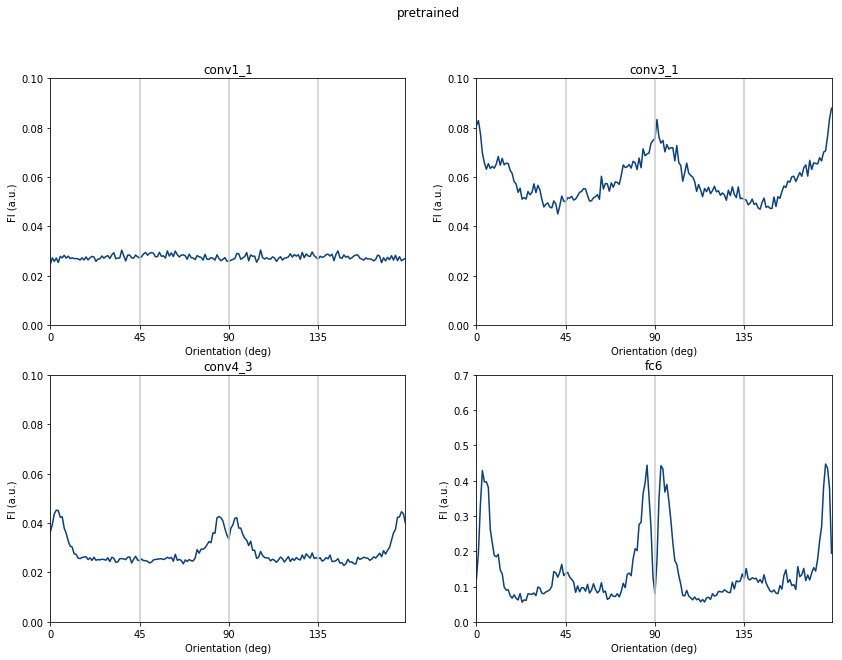

In [4]:
#%%  Plot Fisher information vs. orientation, for one network training set at a time.
# just plotting for a subset of layers.

# Figure 2A, also Figure 7A

# which network to plot here? [0,1,2,3,4] are
# [random, trained upright images, trained 22 deg rot images, trained 45 deg rot images, pretrained]
tr=4  # can change this value to plot the netorks with different training sets

layers2plot = [0,6,12,18]

if tr==4 or tr==0:
  init2plot = [0]
else:
  init2plot = [0,1,2,3]

dd=3
ylims=[[0, 0.1],[0,0.1],[0,0.1],[0,0.7]]

plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42    
plt.rcParams['figure.figsize']=[14,10]

plt.close('all')

plt.figure()
npx = np.ceil(np.sqrt(np.size(layers2plot)))
npy = np.ceil(np.size(layers2plot)/npx)

# loop over layers, making a subplot for each
for ll in range(np.size(layers2plot)):

  plt.subplot(npx,npy, ll+1)
  
  FI_all_init = np.zeros([len(init2plot),nOri])
  
  for ii in init2plot:
   
    fish= all_fisher[tr,ii,:,layers2plot[ll],sf,:,dd] 
    # correct for the different numbers of units in each layer
    nUnits = info['activ_dims'][layers2plot[ll]]**2*info['output_chans'][layers2plot[ll]]  
    fish = fish/nUnits  
    # average over image sets
    FI_all_init[ii,:] = np.mean(fish,axis=0)
    
  # get mean and std, plot errorbars.
  # Errorbars are over network initializations, if there is more than one. 
  # otherwise, no errorbars are plotted.
  meanfish = np.mean(FI_all_init,0)    
  errfish = np.std(FI_all_init,0)
 
  if len(init2plot)>1:
    plt.errorbar(ori_axis,meanfish,errfish,ecolor=colors_main[color_inds[tr],:],color=[0,0,0])
  else:
    plt.plot(ori_axis,meanfish,color=colors_main[color_inds[tr],:])
  # finish up this subplot    
  plt.title('%s' % (layer_labels[layers2plot[ll]]))

  plt.xlabel('Orientation (deg)')
  plt.xticks(np.arange(0,181,45))
  plt.xlim([np.min(ori_axis),np.max(ori_axis)])
  plt.ylabel('FI (a.u.)')
  
  plt.ylim(ylims[ll])
  
  for xx in np.arange(0,181,45):
      plt.axvline(xx,color=[0.8, 0.8, 0.8])
             
# finish up the entire plot   
plt.suptitle('%s' % (training_strs[tr]))
figname = os.path.join(figfolder, '%s_FisherInfo.pdf' % (training_strs[tr]))
plt.savefig(figname, format='pdf',transparent=True)

Text(0.5,0.98,'pretrained')

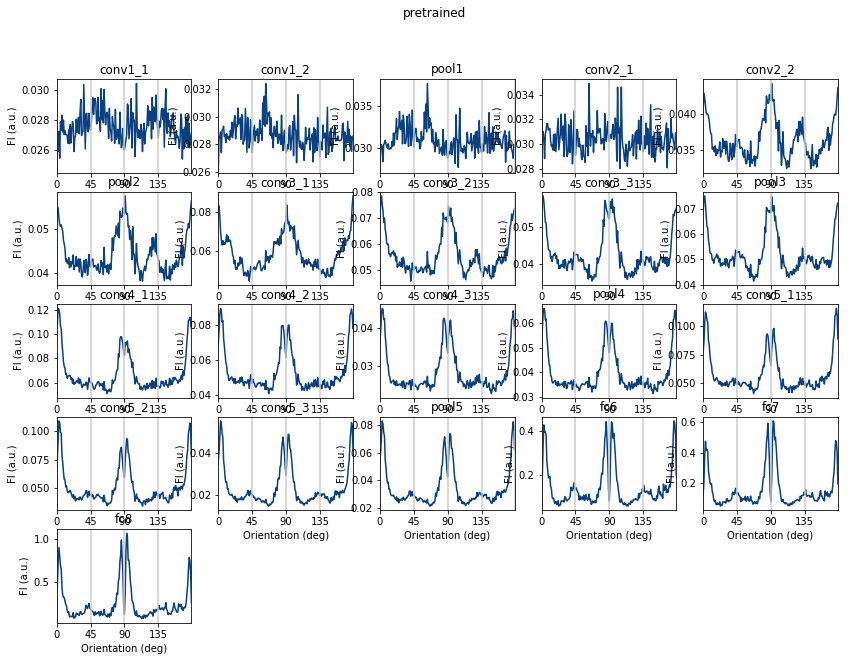

In [5]:
#%%  Fisher info vs. orientation, for ALL layers

# which network to plot here? [0,1,2,3,4] are
# [random, trained upright images, trained 22 deg rot images, trained 45 deg rot images, pretrained]
tr=4 # can change this value to plot the models with different training sets 

layers2plot = np.arange(0,nLayers)

if tr==4 or tr==0:
  init2plot = [0]
else:
  init2plot = [0,1,2,3]

dd=3

plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42    
plt.rcParams['figure.figsize']=[14,10]

plt.close('all')

plt.figure()
npx = np.ceil(np.sqrt(np.size(layers2plot)))
npy = np.ceil(np.size(layers2plot)/npx)

# loop over layers, making a subplot for each
for ll in range(np.size(layers2plot)):

  plt.subplot(npx,npy, ll+1)
  
  FI_all_init = np.zeros([len(init2plot),nOri])
  
  for ii in init2plot:
   
    fish= all_fisher[tr,ii,:,layers2plot[ll],sf,:,dd] 
    # correct for the different numbers of units in each layer
    nUnits = info['activ_dims'][layers2plot[ll]]**2*info['output_chans'][layers2plot[ll]]  
    fish = fish/nUnits  
    # average over image sets
    FI_all_init[ii,:] = np.mean(fish,axis=0)
    
  # get mean and std, plot errorbars.
  # Errorbars are over network initializations, if there is more than one. 
  # otherwise, no errorbars are plotted.
  meanfish = np.mean(FI_all_init,0)    
  errfish = np.std(FI_all_init,0)
 
  if len(init2plot)>1:
    plt.errorbar(ori_axis,meanfish,errfish,ecolor=colors_main[color_inds[tr],:],color=[0,0,0])
  else:
    plt.plot(ori_axis,meanfish,color=colors_main[color_inds[tr],:])
  # finish up this subplot    
  plt.title('%s' % (layer_labels[layers2plot[ll]]))

  plt.xlabel('Orientation (deg)')
  plt.xticks(np.arange(0,181,45))
  plt.xlim([np.min(ori_axis),np.max(ori_axis)])
  plt.ylabel('FI (a.u.)')
 
  for xx in np.arange(0,181,45):
      plt.axvline(xx,color=[0.8, 0.8, 0.8])
             
# finish up the entire plot   
plt.suptitle('%s' % (training_strs[tr]))

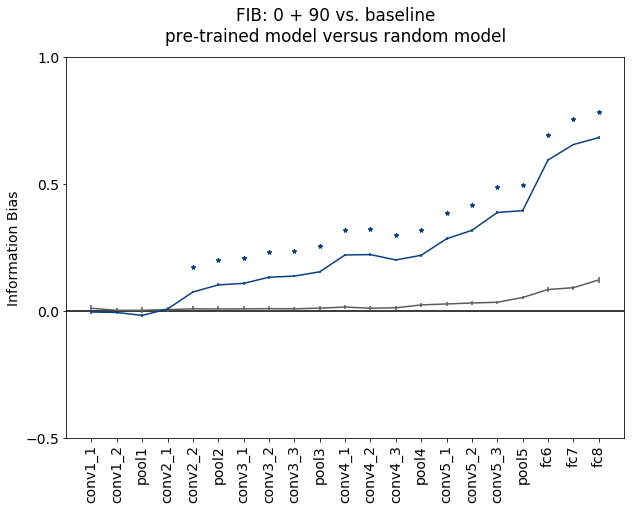

In [6]:
# %% Compute Fisher information bias (FIB-0) comparing pretrained model versus random model. 
# do stats comparing the values between trained and random models.

# Figure 3
  
# which type of FIB to plot?
pp=0  # set to 0, 1 or 2 to plot [FIB-0, FIB-22, FIB-45]

tr2plot=[0,4] # plot just pre-trained and random model here.
ii=0
dd=3
peak_inds=[card_inds, twent_inds,obl_inds]
lstrings=['0 + 90 vs. baseline', '67.5 + 157.5 vs. baseline', '45 + 135 vs. baseline']

plt.rcParams.update({'font.size': 14})
plt.close('all')
fig=plt.figure()
ax=fig.add_subplot(1,1,1)

handles = []
layers2plot = np.arange(0,nLayers,1)

alpha=0.01;
# for each layer, compare bias for trained models versus random models
pvals_trained_vs_random=np.zeros([1, nLayers])
nTotalComp = np.size(pvals_trained_vs_random)
# matrix to store anisotropy index for each layer    
aniso_vals = np.zeros([len(tr2plot),1,nImageSets,np.size(layers2plot)])
rand_seed = 398459
niter=10000
# loop over network layers
for ww1 in range(np.size(layers2plot)):
  # loop over networks with each training set
  for tr in range(len(tr2plot)):
    
    # loop over random image sets
    for kk in range(nImageSets):

      # FI is nOri pts long
      all_fish= np.squeeze(deepcopy(all_fisher[tr2plot[tr],ii,kk,layers2plot[ww1],sf,:,dd]))
      
      # take the bins of interest to get bias
      base_discrim=  all_fish[baseline_inds]
      peak_discrim = all_fish[peak_inds[pp]]
      
      # final value for this FIB: difference divided by sum 
      aniso_vals[tr,ii,kk,ww1] = (np.mean(peak_discrim) - np.mean(base_discrim))/(np.mean(peak_discrim) + np.mean(base_discrim))
      
  # now do pairwise stats: compare trained model versus the random model
  # 4 values per model here
  real_vals_rand = np.squeeze(aniso_vals[0,:,:,ww1])
  real_vals_trained = np.squeeze(aniso_vals[1,:,:,ww1])

  rand_seed = rand_seed+1
  p = plot_utils.nonpar_onetailed_ttest(real_vals_rand,real_vals_trained,niter,rand_seed)
  pvals_trained_vs_random[0,ww1] = p

# do FDR correction on all these pairwise comparisons
[is_sig_fdr, pvals_fdr] = statsmodels.stats.multitest.fdrcorrection(np.ravel(pvals_trained_vs_random),alpha)
is_sig_fdr = np.reshape(is_sig_fdr, np.shape(pvals_trained_vs_random))
pvals_fdr = np.reshape(pvals_fdr, np.shape(pvals_trained_vs_random))
    
# put the line for each FIB onto the plot 
# error bars are across 4 image sets
for tr in range(len(tr2plot)):    
  vals = np.squeeze(np.mean(aniso_vals[tr,:,:,:],1))
  errvals = np.squeeze(np.std(aniso_vals[tr,:,:,:],1)) 
  plt.errorbar(np.arange(0,np.size(layers2plot),1),vals,errvals,color=colors_main[color_inds[tr2plot[tr]],:],zorder=21)
 
# add asterisks for comparisons that were significant
all_xvals = np.arange(0,np.size(layers2plot),1)
is_sig_greater = np.logical_and(is_sig_fdr[tr-1,:], vals>np.mean(np.mean(aniso_vals[0,:,:,:],1),0))
plt.scatter(all_xvals[is_sig_greater], vals[is_sig_greater]+0.1,marker=(5,2,0),s=10,color=colors_main[color_inds[tr2plot[tr]],:],edgecolors=None,zorder=0)

# finish up the entire plot
ylims = [-0.5,1]
xlims = [-1, np.size(layers2plot)]
plt.plot(xlims, [0,0], 'k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.yticks([-0.5,0, 0.5,1])
plt.ylabel('Information Bias')
plt.xticks(np.arange(0,np.size(layers2plot),1),[layer_labels[ii] for ii in layers2plot],rotation=90)

plt.suptitle('FIB: %s\npre-trained model versus random model'%(lstrings[pp]))  
fig.set_size_inches(10,7)
figname = os.path.join(figfolder, 'Pretrained_vs_random_%s.pdf'%lstrings[pp])
plt.savefig(figname, format='pdf',transparent=True)

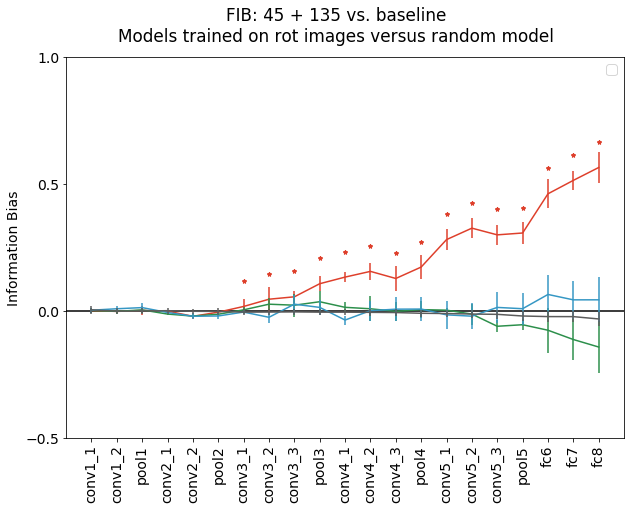

In [7]:
#%% Plot FIB-0, FIB-22, FIB-45: comparing models trained with rotated images, versus random model. 
# do stats comparing the values between trained and random models.

# Figure 8

# which type of FIB to plot?
pp=2  # set to 0, 1 or 2 to plot [FIB-0, FIB-22, FIB-45]

tr2plot=[0,1,2,3] # random model and each of the trained models
nInits=4
sf=0
dd=3
peak_inds=[card_inds, twent_inds,obl_inds]
lstrings=['0 + 90 vs. baseline', '67.5 + 157.5 vs. baseline', '45 + 135 vs. baseline']
plt.rcParams.update({'font.size': 14})
plt.close('all')
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
handles = []
layers2plot = np.arange(0,nLayers,1)

alpha=0.01;
# for each layer, compare bias for trained models versus random models
pvals_trained_vs_random=np.zeros([1, nLayers])
nTotalComp = np.size(pvals_trained_vs_random)
# matrix to store anisotropy index for each layer    
aniso_vals = np.zeros([nTrainingSchemes,nInits,nImageSets,np.size(layers2plot)])
rand_seed = 456546
niter=10000
# loop over network layers
for ww1 in range(np.size(layers2plot)):
  # loop over networks with each training set
  for tr in range(len(tr2plot)):
    # loop over network initializations
    for ii in range(nInits):
      # loop over random image sets
      for kk in range(nImageSets):

        # FI is nOri pts long
        all_fish= np.squeeze(deepcopy(all_fisher[tr2plot[tr],ii,kk,layers2plot[ww1],sf,:,dd]))
        
        # take the bins of interest to get bias
        base_discrim=  all_fish[baseline_inds]
        peak_discrim = all_fish[peak_inds[pp]]
        
        # final value for this layer: difference divided by sum 
        aniso_vals[tr,ii,kk,ww1] = (np.mean(peak_discrim) - np.mean(base_discrim))/(np.mean(peak_discrim) + np.mean(base_discrim))
        
  # stats: compare trained models versus the random models
  # depending on which FIB type we're looking at, compare the models with that 
  # type of bias, versus the random models.
  # 16 total values per training set here
  real_vals_rand = np.reshape(aniso_vals[0,:,:,ww1], [nImageSets*nInits,1])
  real_vals_trained = np.reshape(aniso_vals[pp+1,:,:,ww1], [nImageSets*nInits,1])

  rand_seed = rand_seed+1
  p = plot_utils.nonpar_onetailed_ttest(real_vals_rand,real_vals_trained,niter,rand_seed)
  pvals_trained_vs_random[0,ww1] = p

# do FDR correction on all these pairwise comparisons
[is_sig_fdr, pvals_fdr] = statsmodels.stats.multitest.fdrcorrection(np.ravel(pvals_trained_vs_random),alpha)
is_sig_fdr = np.reshape(is_sig_fdr, np.shape(pvals_trained_vs_random))
pvals_fdr = np.reshape(pvals_fdr, np.shape(pvals_trained_vs_random))
    
# put the line for each FIB onto the plot 
# error bars are across initializations and image sets
for tr in range(len(tr2plot)): 

  vals = np.reshape(aniso_vals[tr,:,:,:],[nInits*nImageSets,np.size(layers2plot)])
  meanvals = np.mean(vals,axis=0)
  errvals = np.std(vals,axis=0)
  plt.errorbar(np.arange(0,np.size(layers2plot),1),meanvals,errvals,color=colors_main[color_inds[tr2plot[tr]],:],zorder=21-tr)

  # put markers on the plot to indicate difference between trained and random models
  if tr==pp+1:
    all_xvals = np.arange(0,np.size(layers2plot),1)
    is_sig_greater = np.logical_and(is_sig_fdr[0,:], meanvals>np.mean(np.mean(aniso_vals[0,:,:,:],1),0))
    plt.scatter(all_xvals[is_sig_greater], meanvals[is_sig_greater]+0.1,marker=(5,2,0),s=10,color=colors_main[color_inds[tr2plot[tr]],:],edgecolors=None,zorder=0)
    
# finish up this subplot 
ylims = [-0.5,1]
xlims = [-1, np.size(layers2plot)]

plt.legend(handles,training_strs)

plt.plot(xlims, [0,0], 'k')
plt.xlim(xlims)
plt.ylim(ylims)
plt.yticks([-0.5,0, 0.5,1])
plt.ylabel('Information Bias')
plt.xticks(np.arange(0,np.size(layers2plot),1),[layer_labels[ii] for ii in layers2plot],rotation=90)

# finish up the entire plot
plt.suptitle('FIB: %s\nModels trained on rot images versus random model'%(lstrings[pp]))    
fig.set_size_inches(10,7)
figname = os.path.join(figfolder, 'Trained_rot_versus_random_%s.pdf'%(lstrings[pp]))
plt.savefig(figname, format='pdf',transparent=True)